Differences compared to NeurIPS version:

 - Dataset only has inhibitory cells now
 - E dataset has new features
 - sPC loadings are scaled differently
 - QDA is performed independently for each cut (instead of pooling probabilities)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from timebudget import timebudget
from copy import deepcopy
from pathlib import Path
from tqdm import tqdm

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

from utils.tree_helpers import get_merged_ordered_classes

**QDA with coupled autoencoder representations**

In [2]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_NM/'
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
htree_file='/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220.csv'
O = sio.loadmat(origdata_pth,squeeze_me=True)

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
n_cvfolds=44
latent_dim=3
aug = 1

#Load all CV sets
CVdict={}
key_list = ['zE','zT','train_ind','val_ind','test_ind']
for cv in tqdm(range(n_cvfolds)):
    cvfold_fname=(f'NM_Edat_pcipfx_aT_{alpha_T:0.1f}_aE_{alpha_E:0.1f}_cs_{lambda_TE:0.1f}'+\
                  f'_ad_{aug:d}_ld_3_bs_200_se_500_ne_1500_cv_{cv:d}_ri_0_500_ft-summary').replace('.','-') + '.mat'
    
    if Path(representation_pth+cvfold_fname).is_file(): 
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        del X
    else:
        print(cvfold_fname,'not found')

100%|██████████| 44/44 [00:26<00:00,  1.63it/s]


In [5]:
a = (list(zip(a,b))).sort(key=lambda x: x[1])

In [9]:
(a,b) = np.unique(O['cluster'],return_counts=True)
s = list(zip(a,b))
s.sort(key=lambda x: x[1])

In [ ]:
n_min_samples = 6
dummy_most_freq = DummyClassifier(strategy="most_frequent")
dummy_prior = DummyClassifier(strategy="stratified")

fiton = 'zT'

for cv in tqdm(CVdict.keys()):
    D = CVdict[cv]
    CVdict[cv]['qda'] = {}
    CVdict[cv]['qda']['n_components'] = []
    CVdict[cv]['qda']['n_htree_classes'] = []
    CVdict[cv]['qda']['acc_train'] = []
    CVdict[cv]['qda']['acc_val'] = []
    CVdict[cv]['qda']['acc_test'] = []
    CVdict[cv]['qda']['acc_most_freq'] = []
    CVdict[cv]['qda']['acc_prior'] = []
    
    for n_classes in [59]:#np.arange(5,61,5):
        
        merged_labels, _ = get_merged_ordered_classes(data_labels=deepcopy(O['cluster']),
                                                      htree_file=htree_file,
                                                      n_required_classes=n_classes)
        
        X_train = deepcopy(D[fiton][D['train_ind']])
        y_train = deepcopy(merged_labels[D['train_ind']])
        ind_train = np.arange(0,np.shape(X_train)[0])

        X_val   = deepcopy(D[fiton][D['val_ind']])
        y_val   = deepcopy(merged_labels[D['val_ind']])
        ind_val = np.arange(0,np.shape(X_val)[0])

        X_test   = deepcopy(D[fiton][D['test_ind']])
        y_test   = deepcopy(merged_labels[D['test_ind']])
        ind_test = np.arange(0,np.shape(X_test)[0])

        #Remove types with low sample counts in training set
        df = pd.DataFrame({'ind':ind_train,'lbl':y_train})
        df_train = df[df.groupby('lbl')['lbl'].transform('count').ge(n_min_samples)]
        keep_ind = df_train['ind'].values
        X_train = X_train[keep_ind,:]
        y_train = y_train[keep_ind]

        #Print types that were removed
        df_train_del = df[df.groupby('lbl')['lbl'].transform('count').lt(n_min_samples)]
        print(df_train_del['lbl'].value_counts())
        
        #Remove types from validation set that are not represented in the training set
        df = pd.DataFrame({'ind':ind_val,'lbl':y_val})
        df_val = df[df['lbl'].isin(y_train)]
        keep_ind = df_val['ind'].values
        X_val = X_val[keep_ind,:]
        y_val = y_val[keep_ind]

        #Remove types from test set that are not represented in the training set
        df = pd.DataFrame({'ind':ind_test,'lbl':y_test})
        df_test = df[df['lbl'].isin(y_test)]
        keep_ind = df_test['ind'].values
        X_test = X_test[keep_ind,:]
        y_test = y_test[keep_ind]

        #QDA related metrics
        n_lbls = np.size(np.unique(y_train))
        qda = QDA(reg_param=1e-2,store_covariance=True)
        qda.fit(X_train,y_train)
        y_train_pred = qda.predict(X_train)
        y_val_pred = qda.predict(X_val)
        y_test_pred = qda.predict(X_test)
        CVdict[cv]['qda']['n_htree_classes'].append(n_classes)
        CVdict[cv]['qda']['n_components'].append(np.unique(qda.classes_).size)
        CVdict[cv]['qda']['acc_train'].append(accuracy_score(y_train, y_train_pred))
        CVdict[cv]['qda']['acc_val'].append(accuracy_score(y_val, y_val_pred))
        CVdict[cv]['qda']['acc_test'].append(accuracy_score(y_test, y_test_pred))
            
        #For dummy classifiers
        dummy_most_freq.fit(D[fiton],merged_labels)
        most_freq_pred=dummy_most_freq.predict(D[fiton])
        dummy_prior.fit(D[fiton],merged_labels)
        prior_pred=dummy_prior.predict(D[fiton])
        CVdict[cv]['qda']['acc_most_freq'].append(accuracy_score(merged_labels, most_freq_pred))
        CVdict[cv]['qda']['acc_prior'].append(accuracy_score(merged_labels, prior_pred))

In [5]:
train_acc = []
test_acc = []
val_acc = []
n_components = []
dummy_prior_acc=[]
dummy_most_freq_acc=[]
for cv in CVdict.keys():
    train_acc.extend(CVdict[cv]['qda']['acc_train'])
    test_acc.extend(CVdict[cv]['qda']['acc_test'])
    val_acc.extend(CVdict[cv]['qda']['acc_val'])
    n_components.extend(CVdict[cv]['qda']['n_components'])
    
    #For dummy classifiers
    dummy_most_freq_acc.extend(CVdict[cv]['qda']['acc_most_freq'])
    dummy_prior_acc.extend(CVdict[cv]['qda']['acc_prior'])

In [15]:
dummy_prior_acc = np.array(dummy_prior_acc)
n_components = np.array(n_components)
dummy_prior_acc[n_components>51]

array([0.02667839, 0.0313691 , 0.03166227, 0.02990325, 0.0313691 ,
       0.02491938, 0.03576664, 0.02961009, 0.03840516, 0.03195544,
       0.03283495, 0.03635298, 0.03224861, 0.0313691 , 0.03342128,
       0.03107593, 0.03987101, 0.03195544, 0.03547347, 0.03312811,
       0.03400762, 0.0351803 , 0.03312811, 0.0351803 , 0.03048959,
       0.03576664, 0.03371445, 0.03254178, 0.03400762, 0.03664614,
       0.03371445, 0.04075051, 0.03664614, 0.03048959, 0.03342128,
       0.03459396, 0.03547347, 0.03400762, 0.03312811, 0.03488713,
       0.03635298, 0.02785107, 0.02931692, 0.03019642])

In [16]:
np.mean(dummy_prior_acc[n_components>51])

0.03320140721196129

Text(0, 0.5, 'Accuracy')

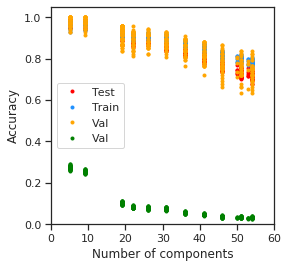

In [10]:
#Visual check before saving results:
plt.figure(figsize=(4,4))
plt.plot(n_components,test_acc,'.',color='red',label='Test')
plt.plot(n_components,train_acc,'.',color='dodgerblue',label='Train')
plt.plot(n_components,val_acc,'.',color='orange',label='Val')
plt.plot(n_components,dummy_prior_acc,'.',color='green',label='Val')
plt.legend()
ax = plt.gca()
ax.set_ylim(0,1.05)
ax.set_xlim(0,60)
ax.set_xlabel('Number of components')
ax.set_ylabel('Accuracy')

In [12]:
res_pth = '/home/rohan/Remote-AI/dat/result/Patchseq_NM_proc/'
df=pd.DataFrame({'n_components':n_components,'test_acc':test_acc,'val_acc':val_acc,'train_acc':train_acc})

fname = 'QDA_'+fiton+'_NM'+\
                '_aT_'+str(alpha_T)+\
                '_aE_'+str(alpha_E)+\
                '_cs_'+str(lambda_TE)+\
                '_ad_'+str(aug)+\
                '_ld_3_bs_200_se_500_ne_1500'
fname = fname.replace('.','-')+'.csv'
df.to_csv(res_pth+fname)

**QDA with PC-CCA baselines**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import pdb
from timebudget import timebudget
from copy import deepcopy

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from scipy.linalg import sqrtm

sns.set()
sns.set_style('ticks',{'axes.grid' : False})
%matplotlib inline

In [ ]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_NM/'
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
O = sio.loadmat(origdata_pth,squeeze_me=True)

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
n_cvfolds=44
latent_dim=10
aug = 1

#Load all CV sets
#with timebudget('load all cv sets'):
CVdict={}
key_list = ['zE','zT','train_ind','val_ind','test_ind']
for cv in tqdm(range(n_cvfolds)):
    cvfold_fname='NM_Edat_pcipfx_aT_'+str(alpha_T)+\
                '_aE_'+str(alpha_E)+\
                '_cs_'+str(lambda_TE)+\
                '_ad_'+str(aug)+\
                '_ld_'+str(latent_dim)+\
                '_bs_200_se_500_ne_1500_cv_'+str(cv)+\
                '_ri_0-summary'
    cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
    if isfile(representation_pth+cvfold_fname): 
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        del X
    else:
        print(cvfold_fname,'not found')

In [28]:
n_min_samples = 6

n_pc_T = 50
n_pc_E = 50
cca_dims = 10
fiton = 'zE'
cca = CCA(n_components=cca_dims, scale=True, max_iter=1e4, tol=1e-06, copy=True)

In [29]:
for cv in tqdm(CVdict.keys()):
    D = deepcopy(CVdict[cv])
    CVdict[cv]['pc_cca_qda'] = {}
    CVdict[cv]['pc_cca_qda']['n_components'] = []
    CVdict[cv]['pc_cca_qda']['n_htree_classes'] = []
    CVdict[cv]['pc_cca_qda']['acc_train'] = []
    CVdict[cv]['pc_cca_qda']['acc_val'] = []
    CVdict[cv]['pc_cca_qda']['acc_test'] = []
    
    XT = deepcopy(O['T_dat'])
    XE = deepcopy(np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1))
    XE[np.isnan(XE)]=0.0
    train_ind = D['train_ind']
    
    #Reduce dims of T data
    if n_pc_T is not None:
        pca = PCA(n_components=n_pc_T)
        pca.fit_transform(XT[train_ind,:])
        XT = pca.transform(XT)
  
    #Reduce dims of E data
    if n_pc_E is not None:
        pca = PCA(n_components=n_pc_E)
        pca.fit_transform(XE[train_ind,:])
        XE = pca.transform(XE)

    #CCA on T and E data
    cca.fit(XT[train_ind,:],XE[train_ind,:])
    D['zT'],D['zE'] = cca.transform(XT,XE)
    
    D['zT'] = D['zT'] - np.mean(D['zT'], axis=0)
    D['zT'] = np.matmul(D['zT'], sqrtm(np.linalg.inv(np.cov(np.transpose(D['zT'])))))
    
    D['zE'] = D['zE'] - np.mean(D['zE'], axis=0)
    D['zE'] = np.matmul(D['zE'], sqrtm(np.linalg.inv(np.cov(np.transpose(D['zE'])))))

    for n_classes in np.arange(5,61,5):

        merged_labels, _ = get_merged_ordered_classes(data_labels=deepcopy(O['cluster']),
                                                      htree_file=htree_file,
                                                      n_required_classes=n_classes)
        
        X_train = deepcopy(D[fiton][D['train_ind']])
        y_train = deepcopy(merged_labels[D['train_ind']])
        ind_train = np.arange(0,np.shape(X_train)[0])

        X_val   = deepcopy(D[fiton][D['val_ind']])
        y_val = deepcopy(merged_labels[D['val_ind']])
        ind_val = np.arange(0,np.shape(X_val)[0])

        X_test   = deepcopy(D[fiton][D['test_ind']])
        y_test = deepcopy(merged_labels[D['test_ind']])
        ind_test = np.arange(0,np.shape(X_test)[0])

        #Remove types with low sample counts in training set
        df = pd.DataFrame({'ind':ind_train,'lbl':y_train})
        df_train = df[df.groupby('lbl')['lbl'].transform('count').ge(n_min_samples)]
        keep_ind = df_train['ind'].values
        X_train = X_train[keep_ind,:]
        y_train = y_train[keep_ind]

        #Print types that were removed
        #df_train_del = df[df.groupby('lbl')['lbl'].transform('count').lt(n_min_samples)]
        #print(df_train_del['lbl'].value_counts())

        #Remove types from validation set that are not represented in the training set
        df = pd.DataFrame({'ind':ind_val,'lbl':y_val})
        df_val = df[df['lbl'].isin(y_train)]
        keep_ind = df_val['ind'].values
        X_val = X_val[keep_ind,:]
        y_val = y_val[keep_ind]

        #Remove types from test set that are not represented in the training set
        df = pd.DataFrame({'ind':ind_test,'lbl':y_test})
        df_test = df[df['lbl'].isin(y_test)]
        keep_ind = df_test['ind'].values
        X_test = X_test[keep_ind,:]
        y_test = y_test[keep_ind]

        #QDA related metrics
        qda = QDA(reg_param=1e-2,store_covariance=True)
        qda.fit(X_train,y_train)
        y_train_pred = qda.predict(X_train)
        y_val_pred = qda.predict(X_val)
        y_test_pred = qda.predict(X_test)
        CVdict[cv]['pc_cca_qda']['n_htree_classes'].append(n_classes)
        CVdict[cv]['pc_cca_qda']['n_components'].append(np.unique(qda.classes_).size)
        CVdict[cv]['pc_cca_qda']['acc_train'].append(accuracy_score(y_train, y_train_pred))
        CVdict[cv]['pc_cca_qda']['acc_val'].append(accuracy_score(y_val, y_val_pred))
        CVdict[cv]['pc_cca_qda']['acc_test'].append(accuracy_score(y_test, y_test_pred))

100%|██████████| 44/44 [02:14<00:00,  3.05s/it]


In [30]:
test_acc = []
val_acc = []
train_acc = []
n_components = []
for cv in CVdict.keys():
    test_acc.extend(CVdict[cv]['pc_cca_qda']['acc_test'])
    val_acc.extend(CVdict[cv]['pc_cca_qda']['acc_val'])
    train_acc.extend(CVdict[cv]['pc_cca_qda']['acc_train'])
    n_components.extend(CVdict[cv]['pc_cca_qda']['n_components'])

Text(0, 0.5, 'Accuracy')

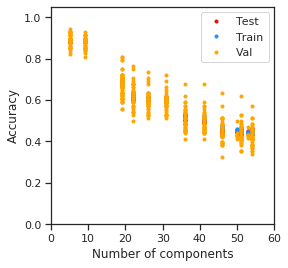

In [31]:
plt.figure(figsize=(4,4))
plt.plot(n_components,test_acc,'.',color='red',label='Test')
plt.plot(n_components,train_acc,'.',color='dodgerblue',label='Train')
plt.plot(n_components,val_acc,'.',color='orange',label='Val')
plt.legend()
ax = plt.gca()
ax.set_ylim(0,1.05)
ax.set_xlim(0,60)
ax.set_xlabel('Number of components')
ax.set_ylabel('Accuracy')

In [32]:
res_pth = '/home/rohan/Remote-AI/dat/result/Patchseq_NM_proc/'
df=pd.DataFrame({'n_components':n_components,'test_acc':test_acc,'val_acc':val_acc,'train_acc':train_acc})

fname = 'QDA_'+fiton+'_PCCCA_'+\
        'NM_Edat_pcipfx_'+str(n_pc_T)+'-'+str(n_pc_E)+'-pc-'+\
        str(cca_dims)+'-cca'
                
fname = fname.replace('.','-')+'.csv'
df.to_csv(res_pth+fname)

**Supervised celltype classification comparisons with linear baselines**

1. QDA parameters should be the same
2. Validation sets for PC-CCA and AE should be the same

In [26]:
import numpy as np
import pandas as pd
import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from copy import deepcopy

sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

gray 54 0.7381812656176133 0.04505711995852515
===
$\lambda_{te}$ = 0.0
lightskyblue 54 0.7015263051259539 0.04745361950935156
===
$\lambda_{te}$ = 0.5
dodgerblue 54 0.6717149546385718 0.052839001016764954
===
$\lambda_{te}$ = 1.0
lightcoral 54 0.5743285833277054 0.054689333386407954
===
PC-CCA (10,10)
red 54 0.5505672992503545 0.06235481153640868
===
PC-CCA (50,50)
gray 54 0.30754035253596274 0.04083755423528475
===
$\lambda_{te}$ = 0.0
lightskyblue 54 0.46075617388172274 0.05267577501462783
===
$\lambda_{te}$ = 0.5
dodgerblue 54 0.4561862632538664 0.057191751321048034
===
$\lambda_{te}$ = 1.0
lightcoral 54 0.36829427523018393 0.04769842339815136
===
PC-CCA (10,10)
red 54 0.4275230183922018 0.04873370097300844
===
PC-CCA (50,50)


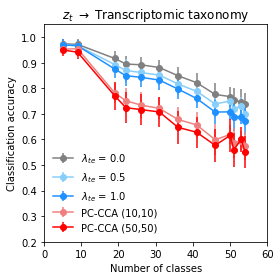

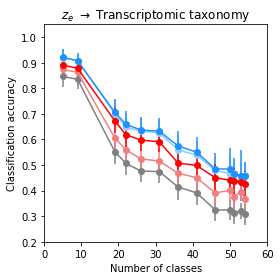

In [14]:
fiton_txt=['z_t','z_e']
for txt_ind,fiton in enumerate(['zT','zE']):
    res_pth = '/home/rohan/Remote-AI/dat/result/Patchseq_NM_proc/'
    #'QDA_{:s}_NM_aT_1-0_aE_1-0_cs_0-5_ad_0_ld_3_bs_200_se_500_ne_1500.csv'.format(fiton),\
    #'QDA_{:s}_NM_aT_1-0_aE_1-0_cs_1-0_ad_0_ld_3_bs_200_se_500_ne_1500.csv'.format(fiton),\
    fname_list = ['QDA_{:s}_NM_aT_1-0_aE_1-0_cs_0-0_ad_0_ld_3_bs_200_se_500_ne_1500.csv'.format(fiton),\
                  'QDA_{:s}_NM_aT_1-0_aE_1-0_cs_0-5_ad_1_ld_3_bs_200_se_500_ne_1500.csv'.format(fiton),\
                  'QDA_{:s}_NM_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3_bs_200_se_500_ne_1500.csv'.format(fiton),\
                  'QDA_{:s}_PCCCA_NM_Edat_pcipfx_10-10-pc-3-cca.csv'.format(fiton),\
                  'QDA_{:s}_PCCCA_NM_Edat_pcipfx_50-50-pc-3-cca.csv'.format(fiton)]

    df_list = [pd.read_csv(res_pth+fname) for fname in fname_list]
    plt.figure(figsize=(4,4))
    col = ['gray',\
           'lightskyblue','dodgerblue',\
           'lightcoral','red']
    lbl = [r'$\lambda_{te}$ = 0.0',\
           r'$\lambda_{te}$ = 0.5',r'$\lambda_{te}$ = 1.0',\
           'PC-CCA (10,10)','PC-CCA (50,50)']
    for i,df in enumerate(df_list):
        x_=[]
        y_=[]
        yerr_=[]
        for n in np.unique(df['n_components'].values):
            ind = df['n_components'].values==n
            x_.append(n)
            y_.append(np.mean(df['val_acc'].values[ind]))
            yerr_.append(np.std(df['val_acc'].values[ind]))
        print(col[i],x_[-1],y_[-1],yerr_[-1])
        plt.errorbar(x_,y_,yerr_,marker='o',color=col[i],label=lbl[i])
        print('===')
        print(lbl[i])
        save_df = pd.DataFrame({'x':x_,'y':y_,'std':yerr_})
        save_df.to_csv(f'/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/NCS/Fig1-{fiton:s}-{i:d}.csv',index=False)


    if fiton=='zT':
        plt.legend()
        plt.legend(frameon=False)
    ax = plt.gca()
    ax.set_ylim(0.2,1.05)
    ax.set_xlim(0,60)
    ax.set_xlabel('Number of classes')
    ax.set_ylabel('Classification accuracy')
    ax.set_title(r'${:s}$ $\rightarrow$ Transcriptomic taxonomy'.format(fiton_txt[txt_ind]))
    
    plt.tight_layout()
    #sns.despine()
    #plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/{:s}-to-celltype.png'.format(fiton),dpi=300)
    plt.savefig(f'/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/NCS/Fig1{fiton:s}.pdf')
    
    

In [3]:
df_list[0]

,Unnamed: 0,n_components,test_acc,val_acc,train_acc
0,0,5,0.814706,0.840580,0.840440
1,1,9,0.829412,0.826087,0.832555
2,2,19,0.541176,0.579710,0.571810
3,3,19,0.541176,0.579710,0.571810
4,4,22,0.470588,0.536232,0.528567
...,...,...,...,...,...
523,523,36,0.397059,0.388060,0.419506
524,524,41,0.373529,0.373134,0.401470
525,525,46,0.311765,0.328358,0.336339
526,526,50,0.291176,0.303030,0.328203


**Reconstruction comparisons**

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import pdb
from timebudget import timebudget
from copy import deepcopy
from os.path import isfile
from tqdm import tqdm

from sklearn.decomposition import PCA
from scipy.linalg import sqrtm
from sklearn.metrics import r2_score as r2
import matplotlib.lines as mlines

In [4]:
from refactor.utils.compute import CCA_extended

In [ ]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_NM/'
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
O = sio.loadmat(origdata_pth,squeeze_me=True)

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
latent_dim=10
n_cvfolds=44
aug = 1

#Load all CV sets
#with timebudget('load all cv sets'):
CVdict={}
key_list = ['XrT','XrE_from_XT','XrT_from_XE','XrE','zE','zT','train_ind','val_ind','test_ind']
for cv in tqdm(range(n_cvfolds)):
    cvfold_fname='NM_Edat_pcipfx_aT_'+str(alpha_T)+\
                '_aE_'+str(alpha_E)+\
                '_cs_'+str(lambda_TE)+\
                '_ad_'+str(aug)+\
                '_ld_'+str(latent_dim)+\
                '_bs_200_se_500_ne_1500_cv_'+str(cv)+\
                '_ri_0_500_ft-summary'
    cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
    if isfile(representation_pth+cvfold_fname): 
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        del X
    else:
        print(cvfold_fname,'not found')

In [4]:
n_pc_T = 50
n_pc_E = 50
cca_dims = latent_dim

In [5]:
XT_orig = O['T_dat']
XE_orig = np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1)
mask_E = np.ones_like(XE_orig)
mask_E[np.isnan(XE_orig)]=0.0
XE_orig[np.isnan(XE_orig)]=0.0

ind_list = ['train','val','test']

for cv in tqdm(CVdict.keys()):
    cca = CCA_extended(n_components=cca_dims, scale=True, max_iter=1e4, tol=1e-06, copy=True)
    
    CVdict[cv]['ae'] = {}
    CVdict[cv]['cca'] = {}
    
    D = deepcopy(CVdict[cv])
    XT = deepcopy(XT_orig)
    XE = deepcopy(XE_orig)
    train_ind = D['train_ind']

    #Reduce dims of T data
    pcaT = PCA(n_components=n_pc_T)
    pcaT.fit_transform(XT[train_ind,:])
    XTpc = pcaT.transform(XT)

    #Reduce dims of E data
    pcaE = PCA(n_components=n_pc_E)
    pcaE.fit_transform(XE[train_ind,:])
    XEpc = pcaE.transform(XE)

    #CCA on T and E data
    cca.fit(XTpc[train_ind,:],XEpc[train_ind,:])
    XTcca,XEcca = cca.transform(XTpc,XEpc)
        
    #Reconstruction from CCA co-ordinates----------------------------
    #Within modality reconstruction
    XrTpc,XrEpc = cca.inverse_transform_xy(XTcca,XEcca)
    XrT = pcaT.inverse_transform(XrTpc)
    XrE = pcaE.inverse_transform(XrEpc)
    
    T_se = (XT_orig - XrT)**2
    E_se = ((XE_orig - XrE)**2)

    #Within modality reconstruction - MSE and R2 calculations
    for s in ind_list:
        CVdict[cv]['cca']['XT_from_XT_'+s] = np.mean(T_se[D[s+'_ind'],:])
        CVdict[cv]['cca']['XE_from_XE_'+s] = np.nanmean(E_se[D[s+'_ind'],:])
        CVdict[cv]['cca']['XT_from_XT_R2_'+s] = r2(XT_orig[D[s+'_ind'],:],XrT[D[s+'_ind'],:])
        CVdict[cv]['cca']['XE_from_XE_R2_'+s] = r2(XE_orig[D[s+'_ind'],:],XrE[D[s+'_ind'],:])
    
    #Cross modality reconstruction
    XrTpc,XrEpc = cca.inverse_transform_xy(XEcca,XTcca) #Input order to inverse_transform_xy is flipped
    XrT = pcaT.inverse_transform(XrTpc)
    XrE = pcaE.inverse_transform(XrEpc)
    
    T_se = (XT_orig - XrT)**2
    E_se = (XE_orig - XrE)**2
    
    for s in ind_list:
        CVdict[cv]['cca']['XT_from_XE_'+s] = np.mean(T_se[D[s+'_ind'],:])
        CVdict[cv]['cca']['XE_from_XT_'+s] = np.nanmean(E_se[D[s+'_ind'],:])
        CVdict[cv]['cca']['XT_from_XE_R2_'+s] = r2(XT_orig[D[s+'_ind'],:],XrT[D[s+'_ind'],:])
        CVdict[cv]['cca']['XE_from_XT_R2_'+s] = r2(XE_orig[D[s+'_ind'],:],XrE[D[s+'_ind'],:])
        
        
    #Within Modality AE
    T_se = (XT_orig - D['XrT'])**2
    E_se = (XE_orig - D['XrE'])**2
    for s in ind_list:
        CVdict[cv]['ae']['XT_from_XT_'+s] = np.mean(T_se[D[s+'_ind'],:])
        CVdict[cv]['ae']['XE_from_XE_'+s] = np.nanmean(E_se[D[s+'_ind'],:])
        CVdict[cv]['ae']['XT_from_XT_R2_'+s] = r2(XT_orig[D[s+'_ind'],:],D['XrT'][D[s+'_ind'],:])
        CVdict[cv]['ae']['XE_from_XE_R2_'+s] = r2(XE_orig[D[s+'_ind'],:],D['XrE'][D[s+'_ind'],:])
        
    #Cross modality reconstruction AE
    T_se = (XT_orig - D['XrT_from_XE'])**2
    E_se = (XE_orig - D['XrE_from_XT'])**2
    for s in ind_list:
        CVdict[cv]['ae']['XT_from_XE_'+s] = np.mean(T_se[D[s+'_ind'],:])
        CVdict[cv]['ae']['XE_from_XT_'+s] = np.nanmean(E_se[D[s+'_ind'],:])
        CVdict[cv]['ae']['XT_from_XE_R2_'+s] = r2(XT_orig[D[s+'_ind'],:],D['XrT_from_XE'][D[s+'_ind'],:])
        CVdict[cv]['ae']['XE_from_XT_R2_'+s] = r2(XE_orig[D[s+'_ind'],:],D['XrE_from_XT'][D[s+'_ind'],:])


100%|██████████| 44/44 [01:01<00:00,  1.40s/it]


In [6]:
result_path = '/home/rohan/Remote-AI/dat/result/Patchseq_NM_proc/'

L={}
L['cv'] = []
for i,cv in enumerate(CVdict.keys()):
    L['cv'].append(cv)
    for k in CVdict[cv]['cca'].keys():
        if i == 0:
            L[k]=[]
        L[k].append(CVdict[cv]['cca'][k])
        
df_cca = pd.DataFrame(L)
fname = 'Recon_CCA_NM_{:d}-{:d}-pc_{:d}_cca.csv'.format(n_pc_T,n_pc_T,cca_dims)
df_cca.to_csv(result_path+fname)



M={}
M['cv'] = []
for i,cv in enumerate(CVdict.keys()):
    M['cv'].append(cv)
    for k in CVdict[cv]['ae'].keys():
        if i == 0:
            M[k]=[]
        M[k].append(CVdict[cv]['ae'][k])

df_ae = pd.DataFrame(M)
fname = 'Recon_AE_NM_aT_{:.1f}_aE_{:.1f}'\
        '_cs_{:.1f}_ad_{:d}_ld_{:d}'.format(alpha_T,alpha_E,lambda_TE,aug,latent_dim)
fname = fname.replace('.','-')+'.csv'
df_ae.to_csv(result_path+fname)

In [16]:
#Results also available for ad_0
result_path = '/home/rohan/Remote-AI/dat/result/Patchseq_NM_proc/'
fname_list = ['Recon_CCA_NM_10-10-pc_3_cca.csv',\
              'Recon_CCA_NM_50-50-pc_3_cca.csv',\
              'Recon_AE_NM_aT_1-0_aE_1-0_cs_0-5_ad_1_ld_3_bs_200_se_500_ne_1500_ft_500.csv',\
              'Recon_AE_NM_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3_bs_200_se_500_ne_1500_ft_500.csv',\
              'Recon_AE_NM_aT_1-0_aE_1-0_cs_0-0_ad_0_ld_3_bs_200_se_500_ne_1500_ft_500.csv'              
              ]
df_list = []

for fname in fname_list:
    #print(fname)
    df_list.append(pd.read_csv(result_path+fname))

In [17]:
#Remove single cross validation fold - something went wrong here.
df_list[3].drop(index=35,inplace=True)

In [49]:
#Source data files
keep_cols = ['XE_from_XE_R2_val','XE_from_XT_R2_val','XT_from_XT_R2_val','XT_from_XE_R2_val']
save_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/NCS/'
df_list[0][keep_cols].to_csv(save_path+'10-10-3-pc-cca.csv',index=False)
df_list[1][keep_cols].to_csv(save_path+'50-50-3-pc-cca.csv',index=False)
df_list[2][keep_cols].to_csv(save_path+'lambda_0_5.csv',index=False)
df_list[3][keep_cols].to_csv(save_path+'lambda_1_0.csv',index=False)
df_list[4][keep_cols].to_csv(save_path+'lambda_0_0.csv',index=False)

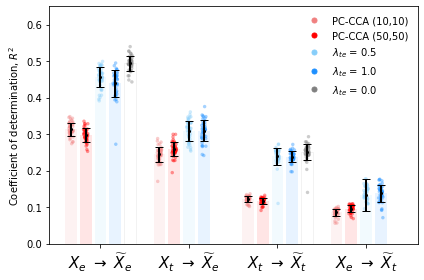

In [45]:
import matplotlib.lines as mlines

col = ['lightcoral','red',\
       'lightskyblue','dodgerblue',\
       'gray',]

#r'$\lambda_{te}$ = 0.5 (aug)',r'$\lambda_{te}$ = 1.0 (aug)',\
lbl = ['PC-CCA (10,10)','PC-CCA (50,50)',\
       r'$\lambda_{te}$ = 0.5',\
       r'$\lambda_{te}$ = 1.0',\
       r'$\lambda_{te}$ = 0.0'] 
h_list=[]
plt.figure(figsize=(6,4))
for grp,key in enumerate(['XE_from_XE_',
                          'XE_from_XT_',
                          'XT_from_XT_',
                          'XT_from_XE_']):
    meas = 'R2_val'
    key = key+meas
    for i,df in enumerate(df_list):

        if (key in ['XE_from_XT_'+meas,'XT_from_XE_'+meas]):
            if i not in [4]: #Ignore cross modal reconstruction for lambda_TE=0
                h = plt.scatter(x = np.array([i+(6*grp)]*df[key].values.size)+(np.random.rand(df[key].values.size,)-0.5)*0.3, 
                                y = df[key].values,
                                s=12,c=col[i],alpha=0.4,label=lbl[i],edgecolor='None')
                plt.bar((i+(6*grp)),np.mean(df[key].values),color=col[i],alpha=0.1)
                plt.errorbar((i+(6*grp)),
                             np.mean(df[key].values),
                             np.std(df[key].values),
                             marker='.',ms=4, color='k',capsize=4, lw=2, elinewidth=2)
                h_leg=mlines.Line2D([], [], color=col[i] ,linestyle='None', marker='o',markersize=5, label=lbl[i])
        else:
            h = plt.scatter(x = np.array([i+(6*grp)]*df[key].values.size)+(np.random.rand(df[key].values.size,)-0.5)*0.3, 
                            y = df[key].values,
                            s=12,c=col[i],alpha=0.4,label=lbl[i],edgecolor='None')
            h_leg=mlines.Line2D([], [], color=col[i],linestyle='None', marker='o',markersize=5, label=lbl[i])
            if col[i]=='gray':
                pass
                plt.bar((i+(6*grp)),np.mean(df[key].values),fc="None",edgecolor=col[i],linewidth=1,alpha=0.1)
            else:
                pass
                plt.bar((i+(6*grp)),np.mean(df[key].values),color=col[i],alpha=0.1)
                
            plt.errorbar((i+(6*grp)),
                         np.mean(df[key].values),
                         np.std(df[key].values),
                         marker='.',ms=4, color='k',capsize=4, lw=2, elinewidth=2)
                
            if grp==0:
                h_list.append(h_leg) #To get handles for legends
                
plt.legend(handles=h_list,labels=lbl,frameon=False)
#plt.legend(frameon=False)

ax = plt.gca()
ax.set_ylim(0,0.65)
ax.set_xlim(-1.5,23.5)
ax.set_xlabel('')
ax.set_xticks(np.array([2,8,14,20]))
ax.set_xticklabels([r'$X_{e}$ $\rightarrow$ $\widetilde{X}_{e}$',
                    r'$X_{t}$ $\rightarrow$ $\widetilde{X}_{e}$',
                    r'$X_{t}$ $\rightarrow$ $\widetilde{X}_{t}$',
                    r'$X_{e}$ $\rightarrow$ $\widetilde{X}_{t}$',])
ax.set_ylabel(r'Coefficient of determination, $R^2$')
ax.tick_params(axis='x', which='major', labelsize=15)
plt.tight_layout()
#plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/Reconstructions'+meas+'.png',dpi=300)
plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/NCS/Reconstructions'+meas+'.pdf')
plt.show()

In [32]:
df[key].values

array([0.25203248, 0.27600777, 0.32614269, 0.32153336, 0.24457255,
       0.31811773, 0.31978632, 0.29423486, 0.34942332, 0.32314187,
       0.29852254, 0.30491071, 0.27294353, 0.26046204, 0.24631456,
       0.31636639, 0.23346711, 0.33896391, 0.34032085, 0.27446684,
       0.17087081, 0.26226222, 0.30207943, 0.28975291, 0.2681876 ,
       0.32352282, 0.24046428, 0.31292836, 0.3528227 , 0.29477266,
       0.30584994, 0.31736996, 0.3198124 , 0.30169311, 0.31045658,
       0.34016898, 0.32100463, 0.26029948, 0.33426297, 0.32986352,
       0.34876764, 0.31418011, 0.30219785, 0.25927071])

**5 dim results**

In [50]:
#Results also available for ad_0
result_path = '/home/rohan/Remote-AI/dat/result/Patchseq_NM_proc/'
fname_list = ['Recon_CCA_NM_50-50-pc_3_cca.csv',\
              'Recon_CCA_NM_50-50-pc_5_cca.csv',\
              'Recon_CCA_NM_50-50-pc_10_cca.csv',\
              'Recon_AE_NM_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3_bs_200_se_500_ne_1500_ft_500.csv',\
              'Recon_AE_NM_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_5_bs_200_se_500_ne_1500_ft_500.csv',\
              'Recon_AE_NM_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_10_bs_200_se_500_ne_1500_ft_500.csv',\
              ]

#'Recon_AE_NM_aT_1-0_aE_1-0_cs_1-0_ad_0_ld_3_bs_200_se_500_ne_1500_ft_500.csv',\
df_list = []

for fname in fname_list:
    #print(fname)
    df_list.append(pd.read_csv(result_path+fname))

In [51]:
#Remove single cross validation fold - something went wrong here.
for i in range(len(df_list)):
    df_list[i].drop(index=35,inplace=True)

In [52]:
from scipy.stats import wilcoxon

for (a,b) in zip([0,1,2],[3,4,5]):
    x = np.concatenate([df_list[i]['XE_from_XE_val'].values for i in [a]])
    y = np.concatenate([df_list[i]['XE_from_XE_val'].values for i in [b]])
    wil_EfromE = wilcoxon(x, y, zero_method='wilcox', correction=False, alternative='two-sided')

    x = np.concatenate([df_list[i]['XE_from_XT_val'].values for i in [a]])
    y = np.concatenate([df_list[i]['XE_from_XT_val'].values for i in [b]])
    wil_EfromT = wilcoxon(x, y, zero_method='wilcox', correction=False, alternative='two-sided')

    x = np.concatenate([df_list[i]['XT_from_XT_val'].values for i in [a]])
    y = np.concatenate([df_list[i]['XT_from_XT_val'].values for i in [b]])
    wil_TfromT = wilcoxon(x, y, zero_method='wilcox', correction=False, alternative='two-sided')

    x = np.concatenate([df_list[i]['XT_from_XE_val'].values for i in [a]])
    y = np.concatenate([df_list[i]['XT_from_XE_val'].values for i in [b]])
    wil_TfromE = wilcoxon(x, y, zero_method='wilcox', correction=False, alternative='two-sided')

    print('\n\n===========')
    print(f'E from E {wil_EfromE}')
    print(f'E from T {wil_EfromT}')
    print(f'T from T {wil_TfromT}')
    print(f'T from E {wil_TfromE}')



E from E WilcoxonResult(statistic=0.0, pvalue=1.120159643476778e-08)
E from T WilcoxonResult(statistic=12.0, pvalue=2.598276732521825e-08)
T from T WilcoxonResult(statistic=0.0, pvalue=1.120159643476778e-08)
T from E WilcoxonResult(statistic=0.0, pvalue=1.120159643476778e-08)


E from E WilcoxonResult(statistic=0.0, pvalue=1.120159643476778e-08)
E from T WilcoxonResult(statistic=83.0, pvalue=2.486525925120387e-06)
T from T WilcoxonResult(statistic=0.0, pvalue=1.120159643476778e-08)
T from E WilcoxonResult(statistic=2.0, pvalue=1.2906165535074668e-08)


E from E WilcoxonResult(statistic=0.0, pvalue=1.120159643476778e-08)
E from T WilcoxonResult(statistic=414.0, pvalue=0.4762033765405743)
T from T WilcoxonResult(statistic=0.0, pvalue=1.120159643476778e-08)
T from E WilcoxonResult(statistic=0.0, pvalue=1.120159643476778e-08)


In [53]:
for (a,b) in zip([3,3],[4,5]):
    x = np.concatenate([df_list[i]['XE_from_XE_val'].values for i in [a]])
    y = np.concatenate([df_list[i]['XE_from_XE_val'].values for i in [b]])
    wil_EfromE = wilcoxon(x, y, zero_method='wilcox', correction=False, alternative='less')

    x = np.concatenate([df_list[i]['XE_from_XT_val'].values for i in [a]])
    y = np.concatenate([df_list[i]['XE_from_XT_val'].values for i in [b]])
    wil_EfromT = wilcoxon(x, y, zero_method='wilcox', correction=False, alternative='two-sided')

    x = np.concatenate([df_list[i]['XT_from_XT_val'].values for i in [a]])
    y = np.concatenate([df_list[i]['XT_from_XT_val'].values for i in [b]])
    wil_TfromT = wilcoxon(x, y, zero_method='wilcox', correction=False, alternative='two-sided')

    x = np.concatenate([df_list[i]['XT_from_XE_val'].values for i in [a]])
    y = np.concatenate([df_list[i]['XT_from_XE_val'].values for i in [b]])
    wil_TfromE = wilcoxon(x, y, zero_method='wilcox', correction=False, alternative='two-sided')
    
    print('\n\n===========')
    print(f'E from E {wil_EfromE}')
    print(f'E from T {wil_EfromT}')
    print(f'T from T {wil_TfromT}')
    print(f'T from E {wil_TfromE}')



E from E WilcoxonResult(statistic=946.0, pvalue=0.9999999943992017)
E from T WilcoxonResult(statistic=412.0, pvalue=0.4613826078740544)
T from T WilcoxonResult(statistic=20.0, pvalue=4.5015379187890815e-08)
T from E WilcoxonResult(statistic=450.0, pvalue=0.7812243079820957)


E from E WilcoxonResult(statistic=946.0, pvalue=0.9999999943992017)
E from T WilcoxonResult(statistic=259.0, pvalue=0.009765051936770068)
T from T WilcoxonResult(statistic=1.0, pvalue=1.2024565921115018e-08)
T from E WilcoxonResult(statistic=379.0, pvalue=0.2563562428167734)


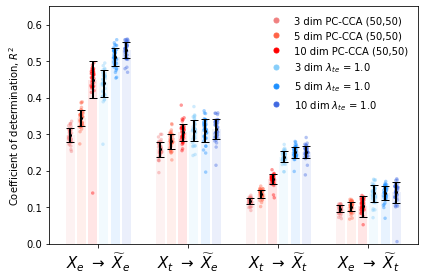

In [63]:
col = ['lightcoral','tomato','red',
       'lightskyblue','dodgerblue','royalblue']
#'grey',
#r'3 dim $\lambda_{te}$ = 1.0, no augmentation',\
#r'$\lambda_{te}$ = 0.5 (aug)',r'$\lambda_{te}$ = 1.0 (aug)',\
lbl = ['3 dim PC-CCA (50,50)',\
       '5 dim PC-CCA (50,50)',\
       '10 dim PC-CCA (50,50)',\
       r'3 dim $\lambda_{te}$ = 1.0',\
       r'5 dim $\lambda_{te}$ = 1.0',\
       r'10 dim $\lambda_{te}$ = 1.0']
       
h_list=[]
plt.figure(figsize=(6,4))
for grp,key in enumerate(['XE_from_XE_',
                          'XE_from_XT_',
                          'XT_from_XT_',
                          'XT_from_XE_']):
    meas = 'R2_val'
    key = key+meas
    for i,df in enumerate(df_list):
        #print(col[i])
        h_leg=mlines.Line2D([], [], color=col[i] ,linestyle='None', marker='o',markersize=5, label=lbl[i])
        plt.scatter(x = np.array([i+(8*grp)]*df[key].values.size)+(np.random.rand(df[key].values.size,)-0.5)*0.3, 
                y = df[key].values,
                s=12,c=col[i],alpha=0.4,label=lbl[i],edgecolor='None')
        plt.bar((i+(8*grp)),np.mean(df[key].values),color=col[i],alpha=0.1)
        plt.errorbar((i+(8*grp)),
                     np.mean(df[key].values),
                     np.std(df[key].values),
                     marker='.',ms=4, color='k',capsize=4, lw=2, elinewidth=2)
        if grp==0:
            h_list.append(h_leg) #To get handles for legends
            #pass
                
plt.legend(handles=h_list,labels=lbl,frameon=False)
ax = plt.gca()
ax.set_ylim(0,0.65)
ax.set_xlabel('')
ax.set_xticks(np.array([0,1,2,3])*8+2.5)
ax.set_xticklabels([r'$X_{e}$ $\rightarrow$ $\widetilde{X}_{e}$',
                    r'$X_{t}$ $\rightarrow$ $\widetilde{X}_{e}$',
                    r'$X_{t}$ $\rightarrow$ $\widetilde{X}_{t}$',
                    r'$X_{e}$ $\rightarrow$ $\widetilde{X}_{t}$',])
ax.set_ylabel(r'Coefficient of determination, $R^2$')
ax.tick_params(axis='x', which='major', labelsize=15)
plt.tight_layout()
#plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/reconstruction_dim_dependence.png',dpi=300)
plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/NCS/Fig_ED_5.jpg',dpi=300)
plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/NCS/Fig_ED_5.pdf')
plt.show()

In [65]:
#Save source data
keep_cols = ['XE_from_XE_R2_val','XE_from_XT_R2_val','XT_from_XT_R2_val','XT_from_XE_R2_val']
save_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/NCS/'
df_list[0][keep_cols].to_csv(save_path+'dim_03_pc-cca.csv',index=False)
df_list[1][keep_cols].to_csv(save_path+'dim_05_pc-cca.csv',index=False)
df_list[2][keep_cols].to_csv(save_path+'dim_10_pc-cca.csv',index=False)
df_list[3][keep_cols].to_csv(save_path+'dim_03_lambda_1_0.csv',index=False)
df_list[4][keep_cols].to_csv(save_path+'dim_05_lambda_1_0.csv',index=False)
df_list[5][keep_cols].to_csv(save_path+'dim_10_lambda_1_0.csv',index=False)

**Get raw data and init:**

This informs the number of pre-determined clusters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import pdb
from timebudget import timebudget
from copy import deepcopy

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score

sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

In [2]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/'
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
O = sio.loadmat(origdata_pth,squeeze_me=True)

**Get n=30 way partitions to compare with unsupervised clustering results**

In [37]:
from analysis_tree_helpers import *

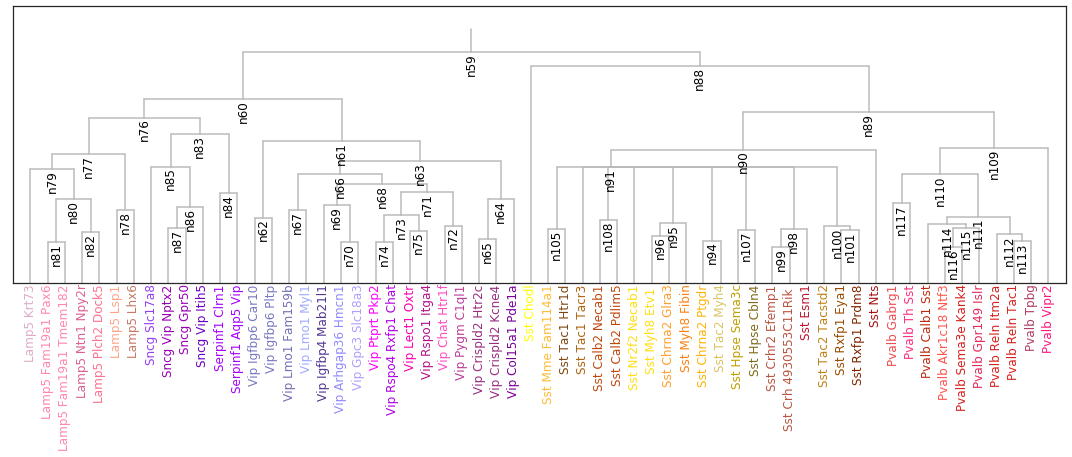

In [38]:
min_samples = 10
n_partitions = 30

#Get inhibitory tree
htree = HTree(htree_file='/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220.csv')
subtree = htree.get_subtree(node='n59')
subtree.plot((15,5),fontsize=12)

#Keep nodes that are well-sampled
hist = pd.Series(O['cluster']).value_counts().to_frame().reset_index()
hist.rename(columns = {'index':'celltype',0:'counts'},inplace=True)
well_sampled_types = hist[hist['counts']>=min_samples]
kept_classes = well_sampled_types['celltype'].values.tolist()



---- Plot: New leaf subset: ----


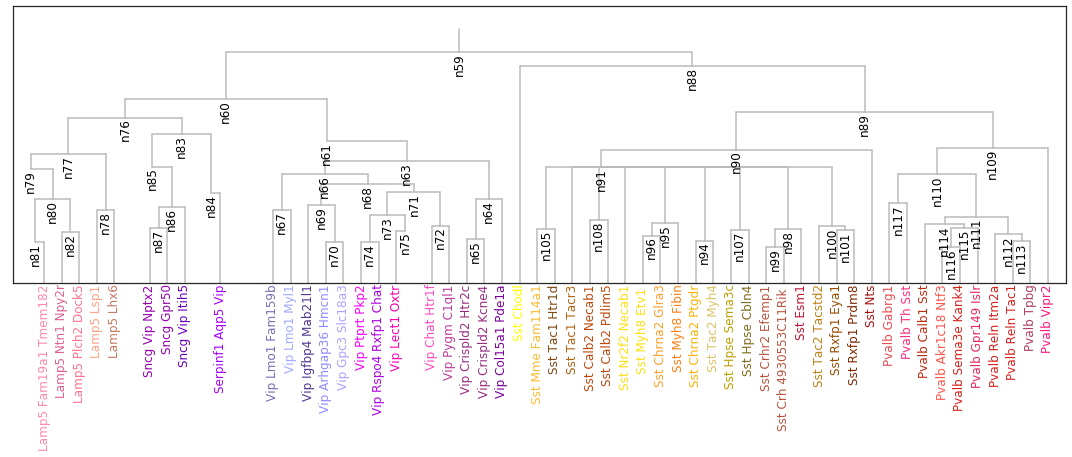



---- Plot: Plot simplified tree: ----
Remove n75 and link ['n73'] to ['Vip Lect1 Oxtr']
Remove n79 and link ['n77'] to ['n80']
Remove n61 and link ['n60'] to ['n63']
Remove n84 and link ['n83'] to ['Serpinf1 Aqp5 Vip']
Remove n81 and link ['n80'] to ['Lamp5 Fam19a1 Tmem182']
Remove n85 and link ['n83'] to ['n86']


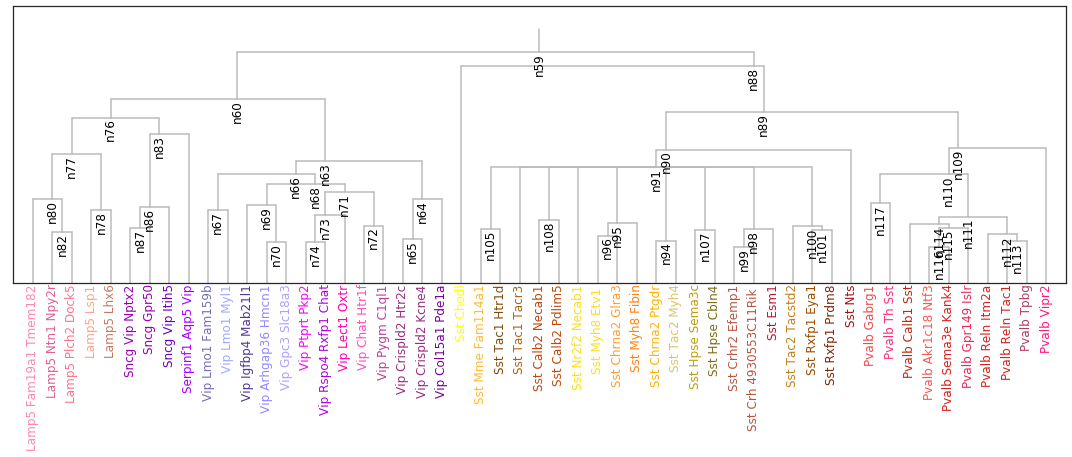

In [39]:
#Obtain all relevant ancestor nodes:
kept_tree_nodes=[]
for node in kept_classes:
    kept_tree_nodes.extend(subtree.get_ancestors(node))
    kept_tree_nodes.extend([node])

kept_subtree_df = subtree.obj2df()
kept_subtree_df = kept_subtree_df[kept_subtree_df['child'].isin(kept_tree_nodes)]

#Plot tree with kept_classes:
print('\n\n---- Plot: New leaf subset: ----')
kept_subtree = HTree(htree_df=kept_subtree_df)
kept_subtree.plot((15,5),fontsize=12)
plt.show()

print('\n\n---- Plot: Plot simplified tree: ----')
mod_subtree,_ = simplify_tree(kept_subtree,skip_nodes=None)
mod_subtree.update_layout()
mod_subtree.plot((15,5),fontsize=12)
plt.show()

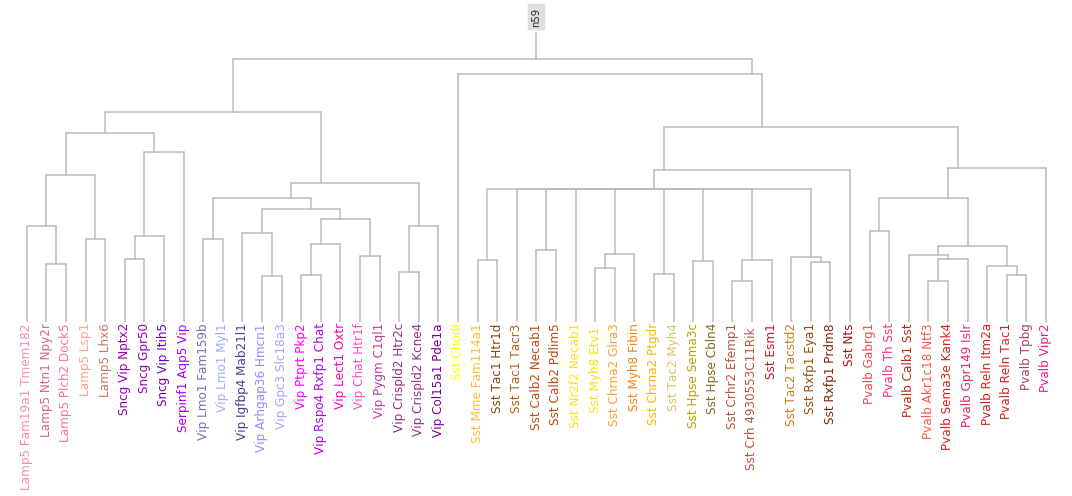

In [43]:
mod_subtree.plot((15,7),fontsize=12,txtleafonly=True)
t = plt.text(26.0,0.3,'n59',horizontalalignment='center',verticalalignment='center',rotation=90,)
t.set_bbox(dict(facecolor='silver', alpha=0.5))
ax = plt.gca()
ax.axis('off')
plt.tight_layout()
ax = plt.gca()
label = ax.xaxis.get_ticklabels()
for l in label:
    l.set_bbox(dict(facecolor='none', edgecolor='red'))
#plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/NCS/Fig_ED_1.jpg',dpi=600)
plt.show()

In [41]:
df = mod_subtree.obj2df()

In [42]:
df[df['child']=='n59']

,x,y,isleaf,child,parent,col
97,26.0,0.257981,False,n59,n4,#000000


In [73]:
np.unique(mod_subtree.child[mod_subtree.isleaf]).shape

(53,)

In [6]:
start_node_name_list = {}
start_node_name_list['n88'] = mod_subtree.child[mod_subtree.parent=='n91'].tolist() + ['Sst Chodl','Sst Nts'] + \
                              ['n117'] + mod_subtree.child[mod_subtree.parent=='n111'].tolist() + ['Pvalb Vipr2']
print(len(start_node_name_list['n88']))

15


In [7]:
start_node_name_list['n60'] = mod_subtree.child[mod_subtree.parent=='n76'].tolist() + \
                              ['n67','n69','n73','n72','n64']  
print(len(start_node_name_list['n60']))

7


In [8]:
htree = mod_subtree

In [9]:
with timebudget('Calculate valid classifications'):
    valid_classifications = {}
    for n in ['n60','n88']:
        print('Subtree with root node: {:s}'.format(n))
        subtree = htree.get_subtree(node=n)
        start_node_list = [Node(name=nn,C_list=subtree.child,P_list=subtree.parent) for nn in start_node_name_list[n]]
        valid_classifications[n]=[]
        valid_classifications[n] = get_valid_classifications(start_node_list,
                                                          C_list=subtree.child,
                                                          P_list=subtree.parent,
                                                          valid_classes=valid_classifications[n])

    for n in ['n60','n88']:
        valid_classifications[n].sort(key=len)
        hist_counts = pd.Series([len(classification) for classification in valid_classifications[n]]).value_counts().to_frame()
        hist_counts.reset_index(inplace=True)
        hist_counts = hist_counts.rename(columns={'index':'n_classes',0:'classifications'}).sort_values(by='n_classes').reset_index(drop=True)

        print(hist_counts.to_string())
        print('Total: {:d} \n'.format(len(valid_classifications[n])))

Subtree with root node: n60
Subtree with root node: n88
    n_classes  classifications
0           7                1
1           8                7
2           9               27
3          10               74
4          11              158
5          12              275
6          13              399
7          14              488
8          15              505
9          16              441
10         17              322
11         18              193
12         19               92
13         20               33
14         21                8
15         22                1
Total: 3024 

    n_classes  classifications
0          15                1
1          16               10
2          17               50
3          18              166
4          19              409
5          20              792
6          21             1246
7          22             1624
8          23             1772
9          24             1624
10         25             1246
11         26              792


In [10]:
from tqdm import tqdm

In [11]:
classifications = []
for i in tqdm(valid_classifications['n60']):
    for j in valid_classifications['n88']:
        if len(i)+len(j)==n_partitions:
            classifications.append(i+j)    
print(len(classifications))

100%|██████████| 3024/3024 [00:06<00:00, 463.17it/s]

240997


In [12]:
#Store all partitions to file
import json
classifications_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
classifications_fname = 'PS_v5_beta_0-4_pc_scaled_ipxf_eqTE_n88_n60_classifications.json'
json_file = json.dumps(classifications)
with open(classifications_path+classifications_fname,"w") as f:
    f.write(json_file)

In [13]:
#Read partitions from file
import json
classifications_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
classifications_fname = 'PS_v5_beta_0-4_pc_scaled_ipxf_eqTE_n88_n60_classifications.json'
with open(classifications_path+classifications_fname) as f:
    classifications = json.load(f)

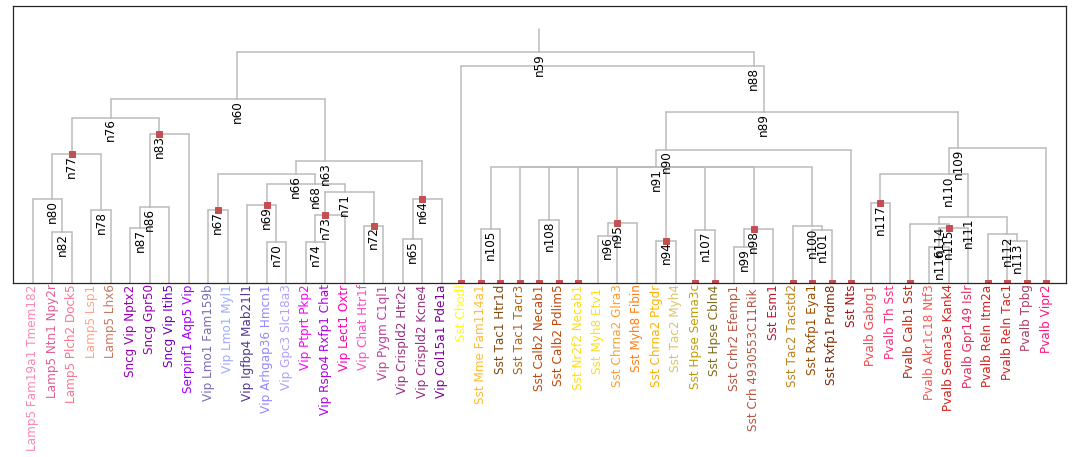

In [19]:
mod_subtree.plot((15,5),fontsize=12)
mod_subtree.plotnodes(classifications[0])
plt.show()

In [14]:
mod_subtree_df = mod_subtree.obj2df()

In [16]:
tree_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
tree_fname = 'PS_v5_beta_0-4_pc_scaled_ipxf_eqTE_well-sampled_inh_tree.json'
mod_subtree_df.to_csv(tree_path+tree_fname)

**Load saved tree and classifications to evaluate**

In [1]:
#Read partitions from file
from copy import deepcopy
import pandas as pd
import json
from analysis_tree_helpers import *

classifications_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
classifications_fname = 'PS_v5_beta_0-4_pc_scaled_ipxf_eqTE_n88_n60_classifications.json'
with open(classifications_path+classifications_fname) as f:
    classifications = json.load(f)
    
tree_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
tree_fname = 'PS_v5_beta_0-4_pc_scaled_ipxf_eqTE_well-sampled_inh_tree.json'
tree_df = pd.read_csv(tree_path+tree_fname)
htree = HTree(htree_df=tree_df)

**Compare partitions with GMM labels**

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import pdb
from timebudget import timebudget
from copy import deepcopy
import pickle 

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import accuracy_score

sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

representation_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/'
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
O = sio.loadmat(origdata_pth,squeeze_me=True)

#Representations
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/'
gmm_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/gmm_fits_us/'

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
fiton='zT'
n_cvfolds = 44

#Load all CV sets 
with timebudget('load all cv sets'):
    CVdict={}
    key_list = ['zE','zT','train_ind','val_ind','test_ind']

    for cv in range(n_cvfolds):
        cvfold_fname='v3_Edat_pcipfx_aT_'+str(alpha_T)+\
                    '_aE_'+str(alpha_E)+\
                    '_cs_'+str(lambda_TE)+\
                    '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+\
                    '_ri_0500_ft-summary'
        cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        del X

with timebudget('fit gmm'):
    best_n_components = 30
    for cv in CVdict.keys():

        fname = 'gmmfit_aT_{:.1f}_aE_{:.1f}_cs_{:.1f}_cv_{:d}_ld_3_ne_1500_fiton_zT_n_{:d}.pkl'.format(alpha_T,
                                                                                                       alpha_E,
                                                                                                       lambda_TE,
                                                                                                       cv,
                                                                                                       best_n_components)
        with open(gmm_pth+fname, 'rb') as fid:
            gmm = pickle.load(fid)

        #Label predictions using GMM fits:
        CVdict[cv]['ccT_lbl'] = gmm.predict(CVdict[cv]['zT'])
        CVdict[cv]['ccE_lbl'] = gmm.predict(CVdict[cv]['zE'])
        #bic[cv] = gmm.bic(CVdict[cv]['zT'])
        
        

load all cv sets took 10.287sec
fit gmm took 854.98ms


In [20]:
len(CVdict)

44

In [49]:
ari_mat = np.zeros((len(CVdict),len(CVdict)))
for i in range(len(CVdict)):
    for j in range(len(CVdict)):
        ari_mat[i,j] = ari(CVdict[i]['ccT_lbl'],CVdict[j]['ccT_lbl'])

In [42]:
from scipy.optimize import linear_sum_assignment
# np.fill_diagonal(ari_mat, 0.5)
# row_ind,col_ind = linear_sum_assignment(-ari_mat)

# ari_mat_ordered = ari_mat.copy()
# ari_mat_ordered = ari_mat_ordered[:,col_ind]
#ari_mat_ordered = ari_mat_ordered[row_ind,:]

In [54]:
ind = np.argsort(df['mseTT'].values)

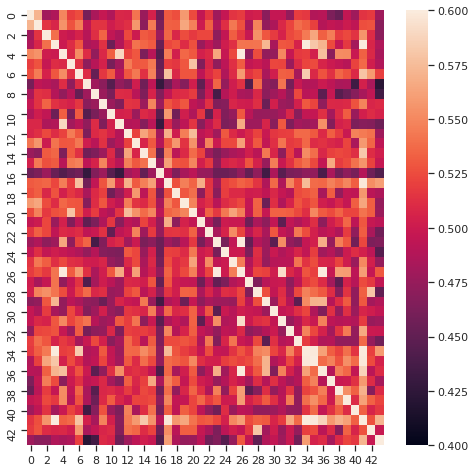

In [56]:
plt.figure(figsize=(8,8))
ari_mat = ari_mat[:,ind]
ari_mat = ari_mat[ind,:]
sns.heatmap(ari_mat,annot=False,vmin=0.4,vmax=0.6)
plt.show()

In [ ]:
#Calculate ARI after merging based on mod_subtree

from tqdm import tqdm

with timebudget('Indexing classification'):
    print(len(classifications))

ari_vals = np.empty((len(classifications),1))
with timebudget('relabeling with ari'):
    for i in tqdm(range(len(classifications),1)):
        new_labels = relabel_ordered_classes_nonhierarchical(data_labels=O['cluster'],
                                                            ref_labels=classifications[i],
                                                            ref_htree=htree)
        x[i] = ari(new_labels,CVdict[cv]['ccT_lbl'])

def relabel_ordered_classes_nonhierarchical(data_labels,ref_labels,ref_htree):
    """
    `data_labels` numpy array is updated based on `ref_labels` as per hierarchy in `ref_htree`.
    `data_labels` not appearing ref_labels or any child node of ref_labels are left unchanged.

    returns:
    new_data_labels
    new_data_label_order
    """
    new_data_labels = data_labels.copy()
    for label in ref_labels:
        labels_to_merge = htree.get_descendants(label,leafonly=True)
        new_data_labels[np.isin(new_data_labels,labels_to_merge)]=label

    return new_data_labels

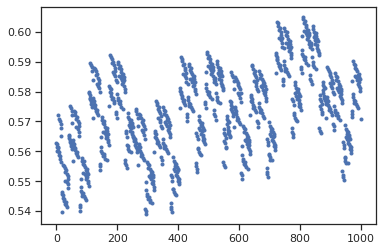

In [35]:
plt.plot(x,'.')

In [38]:
O['cluster']

array(['Vip Gpc3 Slc18a3', 'Sst Calb2 Pdlim5', 'Sst Hpse Cbln4', ...,
       'Lamp5 Fam19a1 Pax6', 'Sncg Vip Nptx2', 'Sncg Vip Itih5'],
      dtype=object)

In [44]:
kept_cells = np.isin(O['cluster'],htree.child[htree.isleaf])

**Compare ARI, BIC and MSE**

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import pdb
from timebudget import timebudget
from copy import deepcopy
import pickle 

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import accuracy_score


sns.set()
#sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

In [25]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/'
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
gmm_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/gmm_fits_restricted/'

O = sio.loadmat(origdata_pth,squeeze_me=True)
#XT_orig = O['T_dat']
#XE_orig = np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1)

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
n_cvfolds = 44
perc = 100#95 97 100
best_n_components = 30

#Load all CV sets and get labels from fitted GMM
with timebudget('load all cv sets'):
    CVdict={}
    key_list = ['zE','zT','kept','ccT_lbl']

    for cv in range(n_cvfolds):
        cvfold_fname='v3_Edat_pcipfx_aT_'+str(alpha_T)+\
                    '_aE_'+str(alpha_E)+\
                    '_cs_'+str(lambda_TE)+\
                    '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+\
                    '_ri_0500_ft-summary'
        cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
        
        CV = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)

        #Calculate the cells that were reconstructed well, and are coupled well.
        RT = np.mean((CV['XrT'] - O['T_dat'])**2,axis=1)
        RE = np.nanmean((CV['XrE'] - np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1))**2,axis=1)
        CTE= np.mean((CV['zT'] - CV['zE'])**2,axis=1)
        kept = np.logical_and(RT<np.percentile(RT,perc),RE<np.percentile(RE,perc))
        kept = np.logical_and(keep,CTE<np.percentile(CTE,perc))
        CV['kept'] = kept
        
        #Obtain labels from the GMM fits
        fname = 'gmmfit_restricted_perc_{:.1f}_aT_{:.1f}_aE_{:.1f}_cs_{:0.1f}_cv_{:d}_ld_3_ne_1500_fiton_zT_n_{:d}'.format(perc,
                                                                                                                           alpha_T,
                                                                                                                           alpha_E,
                                                                                                                           lambda_TE,
                                                                                                                           cv,
                                                                                                                           best_n_components)
        fname = fname.replace('.','-')+'.pkl'
        with open(gmm_pth+fname, 'rb') as fid:
            gmm = pickle.load(fid)
        CV['ccT_lbl'] = gmm.predict(CV['zT'])

        #Copy results to dictionary for each fold
        CVdict[cv] = {key:CV[key] for key in key_list}
        del CV        

load all cv sets took 11.338sec


In [26]:
#D={}
D[perc]=deepcopy(CVdict)

In [35]:
D.keys()

dict_keys([95, 97, 100])

In [27]:
from sklearn.metrics import adjusted_rand_score as ari
def get_ari_mat(Xdict):

    ari_mat = np.zeros((len(Xdict),len(Xdict)))
    for i in range(len(Xdict)):
        for j in range(len(Xdict)):
            kept_i = Xdict[i]['kept']
            kept_j = Xdict[j]['kept']
            kept = np.logical_and(kept_i,kept_j)
            ari_mat[i,j] = ari(Xdict[i]['ccT_lbl'][kept],
                               Xdict[j]['ccT_lbl'][kept])
    return ari_mat

In [28]:
ari_95 = get_ari_mat(D[95])
ari_97 = get_ari_mat(D[97])
ari_100 = get_ari_mat(D[100])

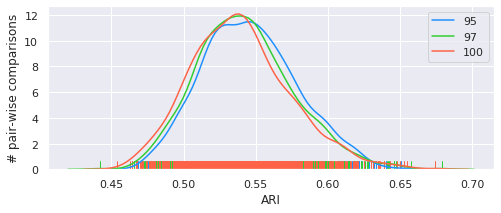

In [52]:
plt.figure(figsize=(8,3))
sns.distplot(ari_95[ari_95<1.0], bins=20, hist=False, kde=True, rug=True, color = 'dodgerblue', label='95')
sns.distplot(ari_97[ari_97<1.0], bins=20, hist=False, kde=True, rug=True, color = 'limegreen', label='97')
sns.distplot(ari_100[ari_100<1.0], bins=20, hist=False, kde=True, rug=True, color = 'tomato', label='100')
plt.legend()
ax = plt.gca()
ax.set_xlabel('ARI')
ax.set_ylabel('# pair-wise comparisons')
plt.show()

In [ ]:
import pandas as pd
import json

In [ ]:
classifications_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
classifications_fname = 'PS_v5_beta_0-4_pc_scaled_ipxf_eqTE_n88_n60_classifications.json'
with open(classifications_path+classifications_fname) as f:
    classifications = json.load(f)

In [ ]:
len(classifications)

In [ ]:
ind = []
best = np.array(classifications[ind[-1]])
for i in range(-2,-100,-1):
    best = np.array(best[np.isin(best,classifications[ind[i]])])